# My Angry Faces

Using [Microsoft Cognitive Serices Emotion API](https://www.microsoft.com/cognitive-services/en-us/emotion-api#detection) for emotions detection on VK photos. 

Instructions:
- get IPython (Jupyter) Notebook (simplest way - download [Anaconda](https://www.continuum.io/downloads))
- register on [Microsoft Cognitive Serices](https://www.microsoft.com/cognitive-services/en-us/emotion-api#detection) and get key for free 30,000 API calls
- give my app access to obtain photos - run https://oauth.vk.com/authorize?client_id=5578186&scope=photos&redirect_uri=https://oauth.vk.com/blank.html&display=page&v=5.0&response_type=token (you can register your own desktop app in VK at https://vk.com/apps?act=manage and change client_id)
- copy access_token from obtained link
- select prefered album_id (if None than will load photos on which user tagged) and insert your user_id
- Run all cells and enjoy! (note that API's performance is 20 photos/min)

In [1]:
import requests
import json
import time
import pandas as pd
import matplotlib.patches as patches
import urllib, cStringIO
from PIL import Image
import itertools

%pylab
%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [3]:
# paste your keys here
access_token = '5593df4f83461b6626f75c36c0773e7c9bfb562308c13eef102e9a01ed'
cognitive_key = '99e9a8d887b7420c77407fbe501'

user_id = 17149186
album_id = None # e.g. '221549386' for https://vk.com/album17149186_221549386, if None than load photos on which user tagged

In [5]:
photo_links = []

vk_api = 'https://api.vk.com/method/'

if album_id is not None:
    resp = requests.get(vk_api + 'photos.get?uid=%s&access_token=%s&aid=%s'% (user_id, access_token, album_id))
    photos_json = json.loads(resp.content)
    for photo in photos_json['response']:
        photo_links.append(photo['src_big'])
else:
    resp = requests.get(vk_api + 'photos.getUserPhotos?user_id=%s&access_token=%s&count=100'% (user_id, access_token))
    photos_json = json.loads(resp.content)
    offset = 0
    while resp.status_code == 200 and len(photo_links) < photos_json['response'][0]:
        offset += 100
        for photo in photos_json['response'][1:]:
            photo_links.append(photo['src_big'])
        resp = requests.get('https://api.vk.com/method/photos.getUserPhotos?\
                            user_id=%s&access_token=%s&count=100&offset=%s'% (user_id, access_token, offset))
        photos_json = json.loads(resp.content)
        
print 'Photos loaded: {}'.format(len(photo_links))

Photos loaded: 1199
[u'https://pp.vk.me/c39/v39564/312/r_z3MZUQnrk.jpg', u'https://pp.vk.me/c39/v39564/31b/O4lQTaG9C2o.jpg', u'https://pp.vk.me/c39/v39564/321/bPpFRGkeyrU.jpg', u'https://pp.vk.me/c39/v39564/324/kQ1t8n6r6ow.jpg', u'https://pp.vk.me/c39/v39564/339/4WuYAf7P86o.jpg']


In [7]:
cogn_url = 'https://api.projectoxford.ai/emotion/v1.0/recognize'
headers = {'content-type': 'application/json', 
           'Ocp-Apim-Subscription-Key' : cognitive_key}
faces_raw = []

def get_faces(link):
    payload = {'url': link}
    resp = requests.post(cogn_url, data=json.dumps(payload), headers=headers)
    time.sleep(3)
    if resp.ok:
        return resp.content
    else:
        print photo_links.index(link), link

In [8]:
jobs = jobs_manager()

Wait when job done:

In [9]:
# %job [faces_raw.append(get_faces(photo_links[x])) for x in log_progress(range(0, len(photo_links)))]

Starting job # 0 in a separate thread.


In [ ]:
# run in the same thread instead of new one for consistency
for link in photo_links:
    faces_raw.append(get_faces(link))

Every face json is like:

>{
>    "faceRectangle": {

>      "height": 51,
>      "left": 280,
>      "top": 229,
>      "width": 51
>    },
>    "scores": {

>      "anger": 9.555069E-07,
>      "contempt": 7.930165E-08,
>      "disgust": 3.83997758E-06,
>      "fear": 7.086758E-08,
>      "happiness": 0.999966741,
>      "neutral": 2.76997253E-05,
>      "sadness": 4.66402241E-07,
>      "surprise": 1.537779E-07
>    }
>  }

Eight emotions, every number mean the probability ot the emotion.

In [15]:
faces = [face for face in faces_raw if face]
len(faces) #how many faces totally found

1197

In [57]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
df = pd.DataFrame(columns=itertools.chain(['photo', 'rectangle'], emotions))

In [58]:
pd.options.display.float_format = '{:,.4f}'.format
for index, data in enumerate(faces_raw):
    if data:
        js = json.loads(data)
        for face in js:
            df.loc[df.shape[0]] = list(itertools.chain([photo_links[index], face['faceRectangle']], 
                                                  [face['scores'][emotion] for emotion in emotions]))
df[0:3]

,photo,rectangle,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise
0,https://pp.vk.me/c39/v39564/312/r_z3MZUQnrk.jpg,"{u'width': 39, u'top': 151, u'left': 116, u'he...",0.0028,0.0146,0.0019,0.0002,0.1399,0.8308,0.0079,0.0019
1,https://pp.vk.me/c39/v39564/321/bPpFRGkeyrU.jpg,"{u'width': 50, u'top': 213, u'left': 397, u'he...",0.0000,0.0000,0.0000,0.0000,0.9996,0.0003,0.0000,0.0001
2,https://pp.vk.me/c39/v39564/321/bPpFRGkeyrU.jpg,"{u'width': 49, u'top': 193, u'left': 226, u'he...",0.0000,0.0014,0.0000,0.0000,0.9769,0.0213,0.0001,0.0002


In [59]:
len(df.photo.unique())

304

In [60]:
df.to_csv('faces_data.csv') #store to disc

In [4]:
df.describe().transpose()[['min', '25%', '50%', '75%', 'max', 'count']]

,min,25%,50%,75%,max,count
Unnamed: 0,0.0000,127.5000,255.0000,382.5000,510.0000,511.0000
anger,0.0000,0.0000,0.0001,0.0012,0.4322,511.0000
contempt,0.0000,0.0001,0.0012,0.0051,0.4864,511.0000
disgust,0.0000,0.0000,0.0001,0.0007,0.0782,511.0000
fear,0.0000,0.0000,0.0000,0.0001,0.0155,511.0000
happiness,0.0000,0.0141,0.4988,0.9836,1.0000,511.0000
neutral,0.0000,0.0112,0.4326,0.9348,0.9996,511.0000
sadness,0.0000,0.0000,0.0004,0.0028,0.3408,511.0000
surprise,0.0000,0.0000,0.0001,0.0011,0.4301,511.0000


So we get the data and now can play with it. Better accuracy reached for 'happines' and 'neutral' and 95% of my photos have greatest probability with this two emotions. Let's find out which faces have highest probability among other emotions:

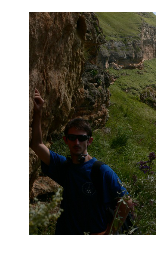

In [5]:
def get_photo(link):
    file = cStringIO.StringIO(urllib.urlopen(link).read())
    img = Image.open(file)
    return img

def show_photo(link, ax):
    img = get_photo(link)
    im = ax.imshow(img, aspect='equal')
    ax.axis('off')
    return im

show_photo(df['photo'][270], plt.gca())

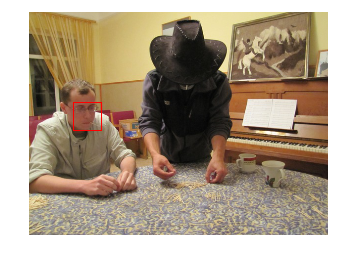

In [17]:
def display_rectangle(index, ax):
    show_photo(df['photo'][index], ax)
    rect = patches.Rectangle((df['rectangle'][index]['left'], df['rectangle'][index]['top']),
                             df['rectangle'][index]['width'], df['rectangle'][index]['height'],
                             linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
display_rectangle(260, plt.gca())

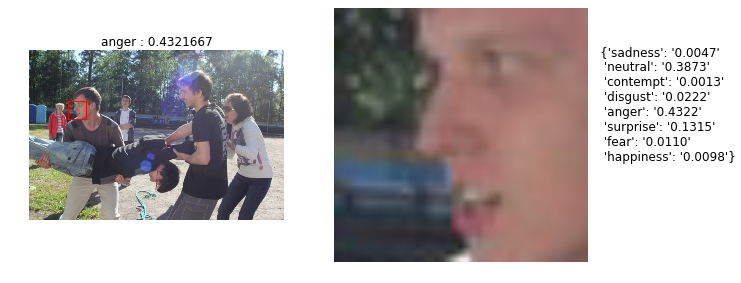

In [20]:
def plot_face(index, emotion, value, figsize=[5,5]):
    fv = dict(zip(emotions, map(lambda l: '{:1.4f}'.format(l), df[emotions][index:index+1].values[0])))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize)
    display_rectangle(index, ax1)
    ax1.set_title('%s : %s' % (emotion, value))
    im = get_photo(df['photo'][index])
    imarray = numpy.asarray(im)
    rect = df['rectangle'][index]
    face = imarray[rect['top']:(rect['top']+rect['height']), rect['left']:(rect['left']+rect['width']), :]
    ax2.imshow(face, aspect='equal')
    ax2.axis('off')
    ax2.text(1.05, 0.4, '%s' % str(fv).replace(',', '\n'), transform=ax2.transAxes, fontsize=12)
    plt.show()

emotion = 'anger'
plot_face(df[emotion].argmax(), emotion, df[emotion].max(), figsize=[10,10])

Finally - all emotions:

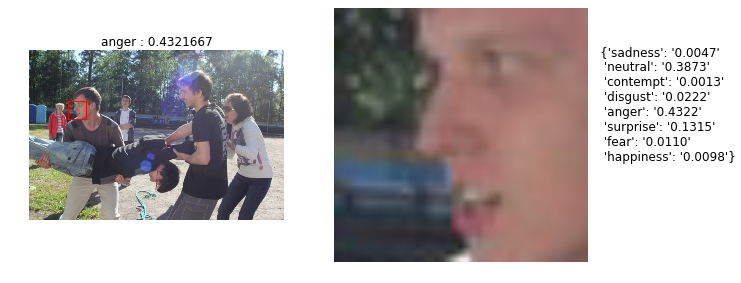

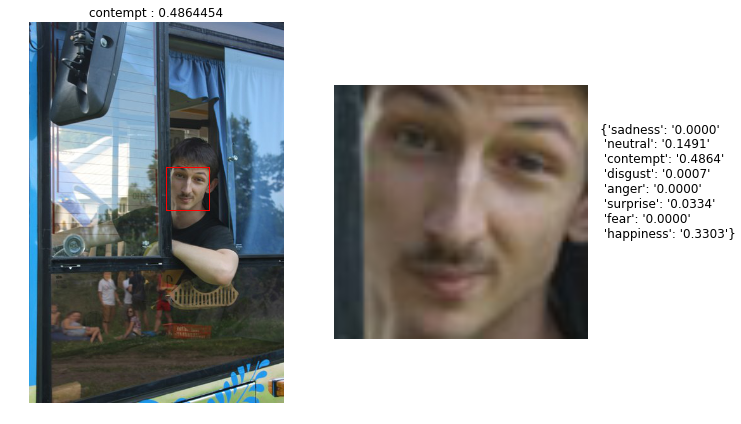

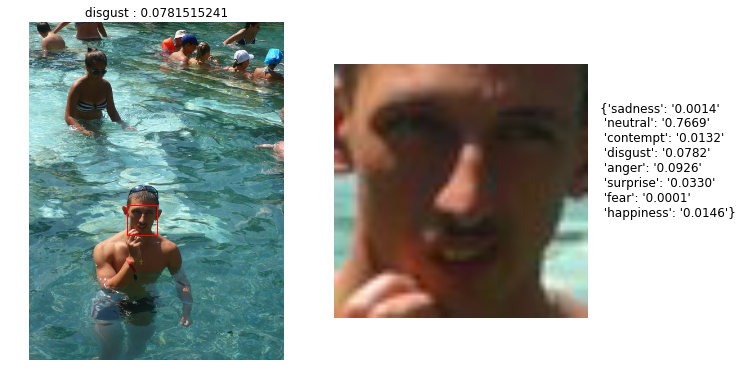

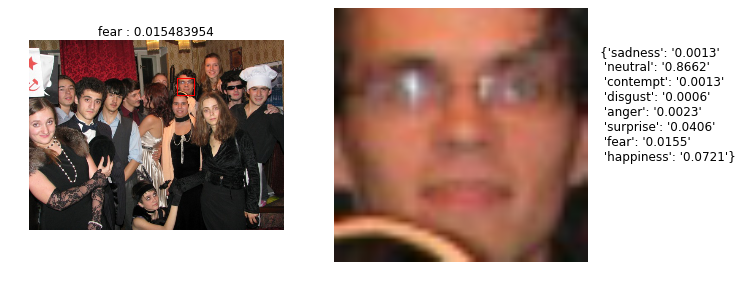

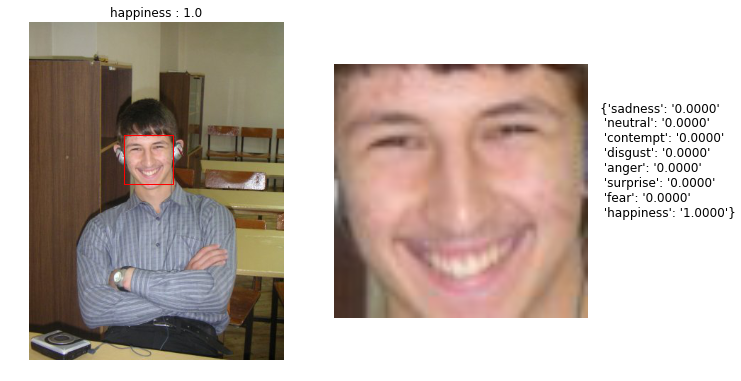

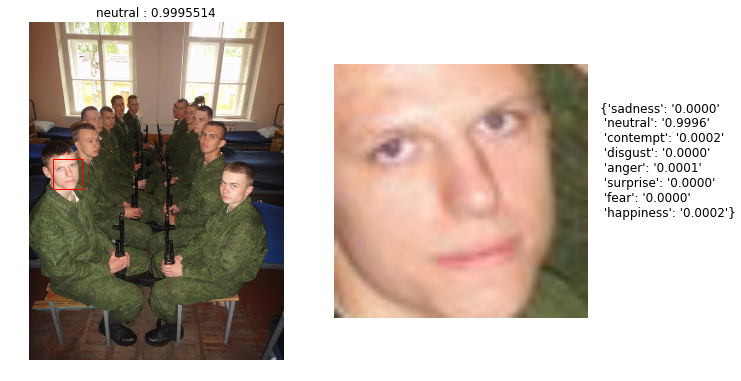

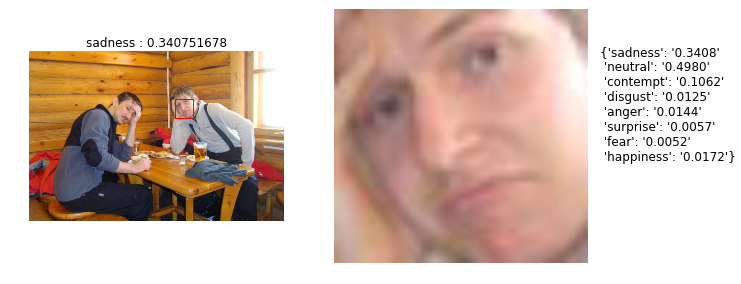

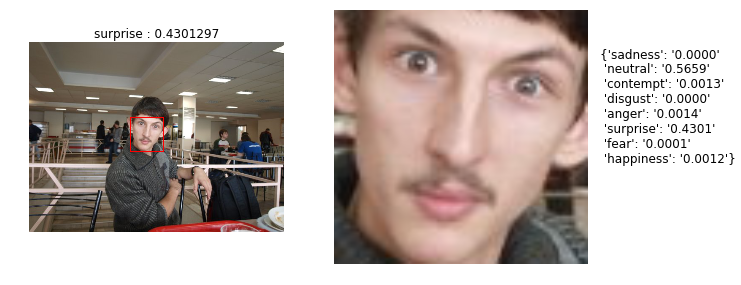

In [31]:
for emotion in emotions:
    plot_face(df[emotion].argmax(), emotion, df[emotion].max(), figsize=[10,10])